In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from graphviz import Digraph

In [2]:
class Value:
    def __init__(self, data, children=(), _op='',label=''):
        self.data = data
        self._prev = set(children)
        self.label = label
        self.grad = 0.00
        self._backward = lambda: None
        self._op = _op
    
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        add_out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1 * add_out.grad
            other.grad += 1 * add_out.grad
            
        add_out._backward = _backward
        return add_out
    

    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
            
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        mul_out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * mul_out.grad
            other.grad += self.data * mul_out.grad
            
        mul_out._backward = _backward
        return mul_out
            
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * (other**-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), "**2")
        
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out
    
    
    def __repr__(self):
        return f"Value (data: {self.data})"
    
    def tanh(self):
        tanVal = (math.exp(2 * self.data) - 1)/(math.exp(2 * self.data) + 1)
        output = Value(tanVal, (self, ), "tanh")
        
        def _backward():
            self.grad += (1 - tanVal ** 2) * output.grad
        
        output._backward = _backward    
        return output
    
    def backward(self):
        topo = []
        visited = set()
        
        def build_grad(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_grad(child)
                topo.append(node)
                
        build_grad(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [3]:
def trace(root):

  # sets for all set and nods in graph.
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)

  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)

  for n in nodes:

    uid = str(id(n))
    # for any value on graph creating a rectangular node
    dot.node(name=uid, label="{ %s | data%.4f | grad%.4f } " % (n.label, n.data, n.grad), shape='record')

    if n._op:
      # if this value is result of some operation them create a node for it
      dot.node(name=uid + n._op, label=n._op)

      # connect this node to it
      dot.edge(uid+ n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
#  Inputs x1, x2;
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# adding weight to input
w1x1 = x1*w1; w1x1.label= 'w1x1'
w2x2 = x2*w2; w2x2.label= 'w2x2'

# adding all the weights and inputs
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'

# model
n = w1x1w2x2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

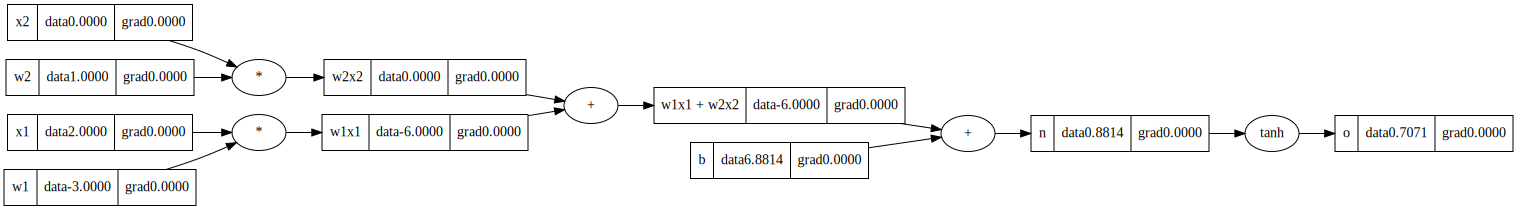

In [5]:
draw_dot(o)

In [ ]:
o.gradient()

In [ ]:
# Creating a Neural Network

import random

class Perceptron:
    def __init__(self, noi):
        # uniform distribution weights with inputs with inputs.
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(noi)] 

        # uniform distribution bias 
        self.bias = Value(random.uniform(-1, 1))
    
    def __call__(self, inps):
        weightedSum = sum((weight*inp for weight, inp in zip(self.weights, inps)), self.bias)
        return weightedSum.tanh()
    
    def parameters(self):
        return self.weights + [self.bias]
    
class Layer:
    
    def __init__(self, noi, nout):
        self.neurons = [Perceptron(noi) for _ in range(nout)]
        
    def __call__(self, inp):
        outs = [neuron(inp) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
          x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

In [ ]:
xs = [[2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

In [ ]:
loss

In [ ]:
for params in n.parameters():
    params.grad = 0.0

In [ ]:
loss.backward()

In [ ]:
for parameter in n.parameters():
    parameter.data += -1 * parameter.grad
    

In [ ]:
epoch = 0

while epoch != 10:
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    for parameter in n.parameters():
        parameter.grad = 0.0
    
    loss.backward()
    
    for parameter in n.parameters():
        parameter.data += -1 * parameter.grad
    
    epoch += 1
    